# Quanta Maths: Integer Addition and Subtraction in Transformers. Scan 200+ LLMs

This Colab uses the app.withmartian.com API to test 200+ models
to see whether given query like "Answer concisely: 4444+5559=" they answer "10003".

In [1]:
# Non-obvious cascading carry tests
# Units column ≥10, all other columns sum to exactly 9
add_tests = [
    ['Answer concisely: 6+5=', '11'], # score 1
    ['Answer concisely: 19+87=', '106'], # score 2
    ['Answer concisely: 774+229=', '1003'], # score 3
    ['Answer concisely: 6587+3416=', '10003'], # score 4
    ['Answer concisely: 22605+77398=', '100003'], # score 5
    ['Answer concisely: 532847+467159=', '1000006'], # score 6
    ['Answer concisely: 5613709+4386294=', '10000003'], # score 7
    ['Answer concisely: 72582383+27417619=', '100000002'], # score 8
    ['Answer concisely: 206727644+793272359=', '1000000003'], # score 9
    ['Answer concisely: 7580116456+2419883549=', '10000000005'], # score 10
    ['Answer concisely: 52449010267+47550989737=', '100000000004'], # score 11
    ['Answer concisely: 888522030597+111477969406=', '1000000000003'], # score 12
    ['Answer concisely: 3764410205738+6235589794265=', '10000000000003'], # score 13
    ['Answer concisely: 45928371046529+54071628953474=', '100000000000003'], # score 14
    ['Answer concisely: 712850394621847+287149605378157=', '1000000000000004'], # score 15
]

# Cascading borrow tests
# Smaller number minus larger number, requires cascading borrows, results in negative answers
sub_tests = [
    ['Answer concisely: 23-47=', '-24'], # score 1
    ['Answer concisely: 156-289=', '-133'], # score 2
    ['Answer concisely: 2047-5183=', '-3136'], # score 3
    ['Answer concisely: 13056-27394=', '-14338'], # score 4
    ['Answer concisely: 240157-583269=', '-343112'], # score 5
    ['Answer concisely: 1350268-2794736=', '-1444468'], # score 6
    ['Answer concisely: 24601379-51836472=', '-27235093'], # score 7
    ['Answer concisely: 135702468-269485731=', '-133783263'], # score 8
    ['Answer concisely: 2461035789-5138274692=', '-2677238903'], # score 9
    ['Answer concisely: 13570246801-27394851639=', '-13824604838'], # score 10
    ['Answer concisely: 246103578924-518372469157=', '-272268890233'], # score 11
    ['Answer concisely: 1357024680135-2739485163728=', '-1382460483593'], # score 12
    ['Answer concisely: 24610357892461-51837246915839=', '-27226889023378'], # score 13
    ['Answer concisely: 135702468013570-273948516372946=', '-138246048359376'], # score 14
    ['Answer concisely: 2461035789246103-5183724691583727=', '-2722688902337624'], # score 15
]

max_score_possible = 15

max_answer_tokens = 1024

In [ ]:
import requests
import pandas as pd
import re
from typing import List, Tuple, Optional, Dict, Any
import os
from dotenv import load_dotenv
import openai
import concurrent.futures
import time
import re
from concurrent.futures import ThreadPoolExecutor, as_completed
import threading
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter
import httpx

In [3]:
def is_ground_truth_correct(answer, ground_truth):
    """
    Returns True if the ground_truth appears as the final number in the answer, ignoring whitespace and punctuation.
    Accepts answers like '13', '13.', '13**', 'The answer is 13', '**13**', 'random text **13** random text', 'boxed{13}'.
    """
    # Remove trailing whitespace and punctuation
    answer_clean = answer.strip().rstrip('.!**')
    # Find all numbers in the answer (including negative numbers and those with commas)
    numbers = re.findall(r'-?[\d,]+', answer_clean)
    
    # Remove commas from the numbers for comparison
    numbers_clean = [num.replace(',', '') for num in numbers]

    answer_no_comma = answer.replace(",", "")

    return (ground_truth == answer_no_comma or
            "**"+ground_truth+"**" in answer or
            "boxed{"+ground_truth+"}" in answer or
            ""+ground_truth+" " in answer_no_comma  or
            ""+ground_truth+"." in answer_no_comma  or
            (numbers_clean and numbers_clean[-1] == ground_truth))

In [4]:
assert is_ground_truth_correct("-14338", "-14338")
assert is_ground_truth_correct("-14338 ", "-14338")
assert is_ground_truth_correct("-14338.", "-14338")
assert is_ground_truth_correct("-14,338", "-14338")
assert is_ground_truth_correct("-14,338 ", "-14338")
assert is_ground_truth_correct("-14,338.", "-14338")
assert not is_ground_truth_correct("-14339", "-14338")
assert is_ground_truth_correct("boxed{-14338}", "-14338")
assert is_ground_truth_correct("**-14338**", "-14338")
assert is_ground_truth_correct("blah blah-14338 blah blah", "-14338")
assert is_ground_truth_correct("135,702,468 - 269,485,731 = **-133,783,263**", "-133783263")
assert is_ground_truth_correct("12123 - 12312 = -14338", "-14338")

## Martian LLMs

Supported martian models are at https://app.withmartian.com/docs/index.html
and https://api.withmartian.com/v1/models

In [5]:
# Fetch Martian model data from the API
martian_models_url = "https://api.withmartian.com/v1/models"
response = requests.get(martian_models_url)
martian_models_json = response.json()

martian_models_json = martian_models_json['data']

In [6]:
# Remove from martian_models_json all models whose name contains ':cheap'
martian_models_json = [model for model in martian_models_json if ':cheap' not in model['id']]
print(f"Models after filtering ':cheap': {len(martian_models_json)}")

Models after filtering ':cheap': 261


In [7]:
def extract_param_size(param_str):
    """
    Convert model name to parameter float (in billions)
    Examples: qwen/qwen-2.5-vl-7b-instruct -> 7.0, qwen/qwen3-14 -> 14.0, qwen/qwen3-235b-a22 -> 235.0
    """
    if param_str is None:
        return None
    
    param_str = str(param_str).lower()
    
    # Handle MoE models like "8x7b" (e.g., Mixtral)
    moe_match = re.search(r'(\d+(?:\.\d+)?)x(\d+(?:\.\d+)?)b?', param_str)
    if moe_match:
        try:
            return float(moe_match.group(1)) * float(moe_match.group(2))
        except (ValueError, AttributeError):
            pass
    
    # Look for patterns like "7b", "14b", "235b"
    param_match = re.search(r'(\d+(?:\.\d+)?)b', param_str)
    if param_match:
        try:
            return float(param_match.group(1))
        except (ValueError, AttributeError):
            pass
    
    # Look for trailing numbers like "-14" or "-72" (without 'b' suffix)
    trailing_match = re.search(r'-(\d+(?:\.\d+)?)(?:-|$)', param_str)
    if trailing_match:
        try:
            return float(trailing_match.group(1))
        except (ValueError, AttributeError):
            pass
    
    return None
    
# Extend the martian_models_json with extracted parameter sizes
for model in martian_models_json:
    model['size'] = extract_param_size(model.get('id'))    

In [8]:
# Extract model names from the new data structure
def extract_model_names():
    """Extract just the model ids from the new data structure"""
    return [model['id'] for model in martian_models_json]

# Group models by provider (if provider info is in id, e.g., 'provider/model')
def get_models_by_provider():
    providers = {}
    for model in martian_models_json:
        provider = model['id'].split('/')[0]
        if provider not in providers:
            providers[provider] = []
        providers[provider].append(model)
    return providers


# Find models by input cost
def find_models_by_cost(top_n=5, reverse=False):
    models_with_cost = [(model['id'], model.get('pricing', {}).get('prompt', float('inf')), model.get('pricing', {}).get('completion', float('inf'))) for model in martian_models_json]
    sorted_by_input = sorted(models_with_cost, key=lambda x: x[1], reverse=reverse)
    return sorted_by_input[:top_n]

# Find largest models by parameter count (if available)
def find_largest_models(top_n=5):
    models_with_params = [(model['id'], model['size']) for model in martian_models_json ]
    models_with_params = [(m[0], m[1]) for m in models_with_params if m[1] is not None]
    sorted_by_params = sorted(models_with_params, key=lambda x: x[1], reverse=True)
    return sorted_by_params[:top_n]

In [9]:
martian_models_names = extract_model_names()

print("=== MARTIAN AI MODELS ANALYSIS ===\n")

providers = get_models_by_provider()
print(f"Number of providers: {len(providers)}")

print(f"\nCheapest Models (input cost):")
models = find_models_by_cost(reverse=False)
for i, model in enumerate(models, 1):
    print( "  ", i, model[0], model[1], model[2])

print(f"\nMost Expensive Models (input cost):")
models = find_models_by_cost(reverse=True)
for i, model in enumerate(models, 1):
    print( "  ", i, model[0], model[1], model[2])

print(f"\nLargest Models:")
models = find_largest_models()
for i, model in enumerate(models, 1):
    print( "  ", i, model[0], model[1])

# Print top-level and nested JSON keys for inspection
def print_json_keys(obj, prefix=""):
    if isinstance(obj, dict):
        for key, value in obj.items():
            print(f"{prefix}{key}")
            print_json_keys(value, prefix + "  ")
    elif isinstance(obj, list) and obj:
        print_json_keys(obj[0], prefix + "[0] ")
print("\nJSON key structure:")
print_json_keys(martian_models_json)

print(f"\nSample model data structure:")
for i in range(3):
    model = martian_models_json[i]
    print(f"   {model}")

=== MARTIAN AI MODELS ANALYSIS ===

Number of providers: 43

Cheapest Models (input cost):
   1 meta-llama/llama-3.2-1b-instruct 0.000000005 0.00000001
   2 liquid/lfm-7b 0.00000001 0.00000001
   3 liquid/lfm-3b 0.00000002 0.00000002
   4 meta-llama/llama-3.1-8b-instruct 0.00000002 0.00000003
   5 meta-llama/llama-3.2-3b-instruct 0.00000002 0.00000002

Most Expensive Models (input cost):
   1 openai/o1-pro 0.00015 0.0006
   2 openai/gpt-4 0.00003 0.00006
   3 anthropic/claude-3-opus-20240229 0.000015 0.000075
   4 anthropic/claude-opus-4-0 0.000015 0.000075
   5 anthropic/claude-opus-4-1 0.000015 0.000075

Largest Models:
   1 mistralai/codestral-2508 2508.0
   2 mistralai/magistral-medium-2506 2506.0
   3 mistralai/magistral-small-2506 2506.0
   4 mistralai/devstral-small-2505 2505.0
   5 mistralai/codestral-2501 2501.0

JSON key structure:
[0] id
[0] pricing
[0]   prompt
[0]   completion
[0]   image
[0]   request
[0]   web_search
[0]   internal_reasoning
[0] added_at
[0] updated_at
[

## Run Models

In [10]:
load_dotenv()
MARTIAN_API_KEY = os.getenv("MARTIAN_API_KEY")
assert MARTIAN_API_KEY, "API key not found. Please set MARTIAN_API_KEY in your .env file."

In [ ]:

client = openai.OpenAI(
    base_url="https://api.withmartian.com/v1",
    api_key=MARTIAN_API_KEY,
    max_retries=0,  # Don't retry on timeout
    timeout=httpx.Timeout(60.0, connect=10.0)  # Separate connect timeout  
)

In [ ]:
def run_model_inference(model_name, prompt, ground_truth, timeout=60):
    """
    Send a model a prompt, get the response, compare it to the ground_truth.
    Any model taking longer than 60 seconds to respond is consider to have failed or died. 
    Returns (answer, success). If timeout, returns ("TIMEOUT", False).
    """
    try:
        # The OpenAI client has its own timeout parameter
        response = client.chat.completions.create(
            model=model_name,
            max_tokens=max_answer_tokens,
            messages=[{"role": "user", "content": prompt}],
            timeout=timeout  
        )
        answer = response.choices[0].message.content.strip()
        success = is_ground_truth_correct(answer, ground_truth)
        return answer, success
    
    except openai.APITimeoutError:
        return "TIMEOUT", False
    except openai.APIError as e:
        return f"Error: {str(e)}", False
    except Exception as e:
        return f"Error: {str(e)}", False

In [ ]:
# Evaluate multiple models concurrently, scoring them based on progressive test success.
def evaluate_models_progressive(tests, max_workers=32):
    model_scores = []

    def score_model(model_name):
        score = 0
        for test_idx, (prompt, ground_truth) in enumerate(tests):
            answer, success = run_model_inference(model_name, prompt, ground_truth)
            
            if success:
                score = test_idx + 1
            else:
                # Check for error codes
                if "TIMEOUT" in str(answer):
                    score = -408  # HTTP timeout code
                    break
                elif isinstance(answer, str) and answer.startswith("Error:"):
                    if "400" in answer:
                        score = -400
                    else:
                        score = -999
                    break
                else:
                    # Just got wrong answer
                    break
        
        return {"model": model_name, "score": score}

    print(f"Evaluating {len(martian_models_json)} models concurrently with {max_workers} workers...")
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        future_to_model = {
            executor.submit(score_model, model_name): model_name 
            for model_name in martian_models_names
        }
        
        for idx, future in enumerate(as_completed(future_to_model), 1):
            model_name = future_to_model[future]
            try:
                result = future.result(timeout=90)  # Add safety margin over API timeout
            except Exception as exc:
                result = {"model": model_name, "score": -999}
            print(f"[{idx}/{len(martian_models_json)}] {result['model']}: Score = {result['score']}")
            model_scores.append(result)
    
    return model_scores

In [14]:
# Run the tasks across all models. This tasks ~20 minutes on a laptop.
add_model_scores = evaluate_models_progressive(add_tests)

Evaluating 261 models concurrently with 16 workers...
[1/261] allenai/olmo-2-0325-32b-instruct: Score = 4
[2/261] allenai/molmo-7b-d: Score = 3
[3/261] amazon/nova-micro-v1: Score = 3
[4/261] alpindale/goliath-120b: Score = 3
[5/261] aion-labs/aion-rp-llama-3.1-8b: Score = 3
[6/261] anthropic/claude-3-5-haiku-20241022: Score = 9
[7/261] anthropic/claude-3-5-sonnet-20240620: Score = 11
[8/261] anthropic/claude-3-5-haiku-latest: Score = 9
[9/261] anthropic/claude-3-5-sonnet-20241022: Score = 12
[10/261] anthracite-org/magnum-v4-72b: Score = 8
[11/261] alfredpros/codellama-7b-instruct-solidity: Score = 1
[12/261] ai21/jamba-mini-1.7: Score = 10
[13/261] anthropic/claude-3-haiku-20240307: Score = 12
[14/261] ai21/jamba-large-1.7: Score = 8
[15/261] anthropic/claude-3-5-sonnet-latest: Score = 15
[16/261] amazon/nova-lite-v1: Score = 13
[17/261] arcee-ai/afm-4.5b: Score = 1
[18/261] anthropic/claude-3-7-sonnet-latest: Score = 12
[19/261] anthropic/claude-3-7-sonnet-20250219: Score = 15
[20/2

In [15]:
# Run the tasks across all models. This tasks ~20 minutes on a laptop.
sub_model_scores = evaluate_models_progressive(sub_tests)

Evaluating 261 models concurrently with 16 workers...
[1/261] alfredpros/codellama-7b-instruct-solidity: Score = 0
[2/261] aion-labs/aion-rp-llama-3.1-8b: Score = 1
[3/261] alpindale/goliath-120b: Score = 1
[4/261] allenai/olmo-2-0325-32b-instruct: Score = 2
[5/261] anthracite-org/magnum-v4-72b: Score = 2
[6/261] ai21/jamba-mini-1.7: Score = 2
[7/261] allenai/molmo-7b-d: Score = 4
[8/261] ai21/jamba-large-1.7: Score = 4
[9/261] anthropic/claude-3-haiku-20240307: Score = 5
[10/261] anthropic/claude-3-5-haiku-20241022: Score = 5
[11/261] anthropic/claude-3-5-haiku-latest: Score = 9
[12/261] anthropic/claude-3-5-sonnet-20241022: Score = 11
[13/261] amazon/nova-micro-v1: Score = 15
[14/261] amazon/nova-lite-v1: Score = 15
[15/261] anthropic/claude-3-5-sonnet-latest: Score = 15
[16/261] anthropic/claude-3-7-sonnet-latest: Score = 15
[17/261] anthropic/claude-3-7-sonnet-20250219: Score = 15
[18/261] anthropic/claude-3-opus-20240229: Score = 11
[19/261] arcee-ai/coder-large: Score = 1
[20/261

# Summarize results

In [16]:
def plot_model_scores(model_scores, title, score_threshold):
    # Summarize number of models by score
    print(title)
    print(f"Total number of models: {len(martian_models_names)}")
    score_counts = Counter([m['score'] for m in model_scores])
    print("Score summary (number of models by score):")
    for score, count in sorted(score_counts.items()):
        print(f"Score {score}: {count} models") 

    # Print total number of models with negative and non-negative scores
    num_negative = sum(count for score, count in score_counts.items() if isinstance(score, int) and score < 0)
    num_nonneg = sum(count for score, count in score_counts.items() if isinstance(score, int) and score >= 0)
    print(f"\nTotal models with negative score: {num_negative}")
    print(f"Total models with non-negative score: {num_nonneg}")

    # Print percentage of models with non-negative scores that scored score_threshold or more
    num_good = sum(count for score, count in score_counts.items() if isinstance(score, int) and score >= score_threshold)
    if num_nonneg > 0:
        percent_good = 100 * num_good / num_nonneg
        print(f"Percentage of non-negative models scoring {score_threshold} or more: {percent_good:.2f}%")
    else:
        print("No models with non-negative scores.")
    print("\n")

    return score_counts

add_score_counts = plot_model_scores(add_model_scores, "Addition Test Scores", max_score_possible)
sub_score_counts = plot_model_scores(sub_model_scores, "Subtraction Test Scores", max_score_possible)

Addition Test Scores
Total number of models: 261
Score summary (number of models by score):
Score -999: 9 models
Score -408: 5 models
Score -400: 6 models
Score 0: 9 models
Score 1: 6 models
Score 2: 20 models
Score 3: 30 models
Score 4: 34 models
Score 5: 24 models
Score 6: 17 models
Score 7: 9 models
Score 8: 19 models
Score 9: 10 models
Score 10: 9 models
Score 11: 10 models
Score 12: 5 models
Score 13: 4 models
Score 14: 1 models
Score 15: 34 models

Total models with negative score: 20
Total models with non-negative score: 241
Percentage of non-negative models scoring 15 or more: 14.11%


Subtraction Test Scores
Total number of models: 261
Score summary (number of models by score):
Score -999: 10 models
Score -408: 3 models
Score -400: 5 models
Score 0: 19 models
Score 1: 20 models
Score 2: 26 models
Score 3: 6 models
Score 4: 14 models
Score 5: 25 models
Score 6: 14 models
Score 7: 9 models
Score 8: 21 models
Score 9: 9 models
Score 10: 11 models
Score 11: 11 models
Score 12: 9 m

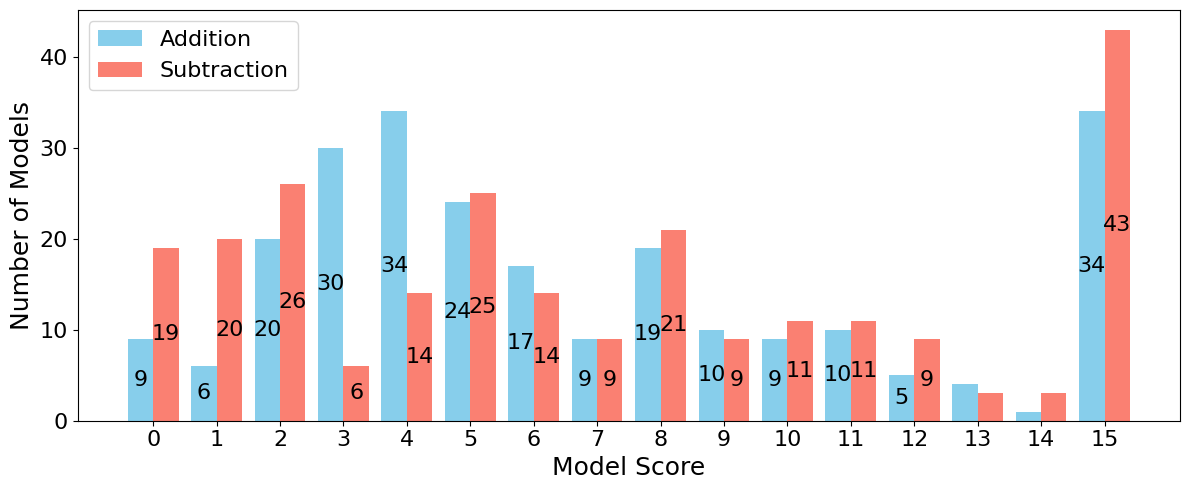

In [17]:
# Bar graph for Addition and Subtraction score counts, x-axis always 0 to 15
score_range = list(range(max_score_possible+1))
add_counts = [add_score_counts.get(s, 0) for s in score_range]
sub_counts = [sub_score_counts.get(s, 0) for s in score_range]

plt.figure(figsize=(12, 5))
bars_add = plt.bar([x-0.2 for x in score_range], add_counts, width=0.4, color='skyblue', label='Addition')
bars_sub = plt.bar([x+0.2 for x in score_range], sub_counts, width=0.4, color='salmon', label='Subtraction')

plt.xlabel('Model Score', fontsize=18)
plt.ylabel('Number of Models', fontsize=18)
plt.xticks(score_range, [str(s) for s in score_range], fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)

# Add count labels inside bars only where count > 4, with larger font
for bar, count in zip(bars_add, add_counts):
    if count > 4:
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height()/2, str(count), ha='center', va='center', fontsize=16, color='black')
for bar, count in zip(bars_sub, sub_counts):
    if count > 4:
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height()/2, str(count), ha='center', va='center', fontsize=16, color='black')

plt.tight_layout()
plt.show()

In [ ]:
# Scatter plot: Output Token Cost vs. Model Score for Addition and Subtraction (x-axis always 0 to 15)
import numpy as np
model_name_to_output_cost = {model[0]: model[2] for model in martian_models_data}

# Addition scores
add_model_names = [entry['model'] for entry in add_model_scores]
add_scores = [entry['score'] for entry in add_model_scores]
add_output_costs = [model_name_to_output_cost.get(name, np.nan) for name in add_model_names]
add_filtered = [(score, cost) for score, cost in zip(add_scores, add_output_costs) if isinstance(score, int) and 0 <= score <= max_score_possible]
if add_filtered:
    add_filtered_scores, add_filtered_output_costs = zip(*add_filtered)
else:
    add_filtered_scores, add_filtered_output_costs = [], []

# Subtraction scores
sub_model_names = [entry['model'] for entry in sub_model_scores]
sub_scores = [entry['score'] for entry in sub_model_scores]
sub_output_costs = [model_name_to_output_cost.get(name, np.nan) for name in sub_model_names]
sub_filtered = [(score, cost) for score, cost in zip(sub_scores, sub_output_costs) if isinstance(score, int) and 0 <= score <= max_score_possible]
if sub_filtered:
    sub_filtered_scores, sub_filtered_output_costs = zip(*sub_filtered)
else:
    sub_filtered_scores, sub_filtered_output_costs = [], []

# Prepare categorical x-axis for scores 0 to max_score_possible
score_range = list(range(max_score_possible+1))
score_to_x = {score: i for i, score in enumerate(score_range)}
add_x_vals = [score_to_x[score] for score in add_filtered_scores]
sub_x_vals = [score_to_x[score] for score in sub_filtered_scores]

plt.figure(figsize=(10,6))
plt.scatter(add_x_vals, add_filtered_output_costs, alpha=0.6, color='blue', label='Addition')
plt.scatter(sub_x_vals, sub_filtered_output_costs, alpha=0.6, color='red', label='Subtraction')
plt.xlabel('Model Score', fontsize=18)
plt.ylabel('Model Output Token Cost (USD per 1M tokens)', fontsize=16)
plt.xticks(score_range, [str(s) for s in score_range], fontsize=16)
plt.yticks(fontsize=16)
plt.yscale('log')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(fontsize=16)
plt.tight_layout()
plt.show()

KeyError: 0

In [ ]:
# List only models with a negative score, zero score or score >= 10 for both Addition and Subtraction
def list_models_by_score(model_scores, label):
    score_to_models = {}
    for entry in model_scores:
        score = entry['score']
        if score <= 0 or score >= 10:
            score_to_models.setdefault(score, []).append(entry['model'])
    print(f"\n{label}:")
    for score in sorted(score_to_models):
        print(f"Models with score {score}:")
        for model in score_to_models[score]:
            print(f"  {model}")

list_models_by_score(add_model_scores, "Addition Models")
list_models_by_score(sub_model_scores, "Subtraction Models")

# Check zero-score model output

On occasion, check the output of the "0 score" models to see if unusual answer formats are hiding correct answers.
If so, is_ground_truth_correct should be updated

In [ ]:
# Re-run models that scored 0 on test[0] and show their outputs
def run_zero_score_models(title, model_scores, tests):
    zero_score_models = [m['model'] for m in model_scores if m['score'] == 0]
    print(f"Re-running {len(zero_score_models)} models that scored 0 on the first test for {title}...")
    outputs = []
    for model_name in zero_score_models:
        try:
            answer, success = run_model_inference(model_name, tests[0][0], tests[0][1])
        except Exception as e:
            answer = f"Error: {str(e)}"
            success = False
        outputs.append({'model': model_name, 'output': answer, 'success': success})
        print(f"Model: {model_name}\nOutput: {answer}\nSuccess: {success}\n{'-'*40}")


#run_zero_score_models("Addition", add_model_scores, add_tests)
#run_zero_score_models("Subtraction", sub_model_scores, sub_tests)

# Check -400 score models

Models can generate -400 scores if a mandatory parameter is missing. This may hide a model that can do addition.
Run the models that give a -400 score and see if the detailed error message shows the root cause.

In [ ]:
# Re-run models that scored -400 and show their outputs and errors
def run_minus_400_score_models(title, model_scores, tests):
    minus_400_models = [m['model'] for m in model_scores if m['score'] == -400]
    print(f"Re-running {len(minus_400_models)} models that scored -400 on the first test for {title}...")
    outputs = []
    for model_name in minus_400_models:
        try:
            answer, success = run_model_inference(model_name, tests[0][0], tests[0][1])
        except Exception as e:
            answer = f"Error: {str(e)}"
            success = False
        outputs.append({'model': model_name, 'output': answer, 'success': success})
        print(f"Model: {model_name}\nOutput/Error: {answer}\nSuccess: {success}\n{'-'*40}")

#run_minus_400_score_models("Addition", add_model_scores, add_tests)
#run_minus_400_score_models("Subtraction", sub_model_scores, sub_tests)

# High Variability Example
The model "alfredpros/codellama-7b-instruct-solidity" has high variability. Sometimes answer is correct

In [ ]:
def run_high_variability_model():
    model_name = "alfredpros/codellama-7b-instruct-solidity"
    for i in range(5):
        answer, success = run_model_inference(model_name, add_tests[0][0], add_tests[0][1])
        print(f"Success: {success}. Output: {answer}")

#run_high_variability_model()

# Ask how the models that score >=14 work

Inconclusive: 

Sometimes the detailed methodology is mathematically incorrect.
Sometimes the outline methodology looks like a sentence from a text book.
The bext valid explanations say the model does addition like a human - line up digit pairs - then sum right digit-pair to-left digit pair calculating carries 
The "concise" setting makes these model reply immediately - unless they have many hidden "thinking tokens" the human approach is not feasible.

Some of these models gpt-4o-mini-search-preview and gpt-4o-search-preview explicitly say they have search/tool access. 
So they can just call a python function to calculate the sum.

In [ ]:
def show_work_for_score_best_models(title, model_scores):
    best_models = [m['model'] for m in model_scores if m['score'] >= 14]
    ground_prompt = "998522030597+1477969406="
    concise_prompt = f"Answer concisely: {ground_prompt}"
    explain_prompt = f"Show your work for {ground_prompt}"
    ground_truth = str(998522030597 + 1477969406)

    print(f"Querying {len(best_models)} models that scored best...")
    for model_name in best_models:
        try:
            answer, _ = run_model_inference(model_name, concise_prompt, ground_truth)
        except Exception as e:
            answer = f"Error: {str(e)}"
        print(f"Model: {model_name}\nOutput: {answer}\n{'-'*40}")

        try:
            answer, _ = run_model_inference(model_name, explain_prompt, ground_truth)
        except Exception as e:
            answer = f"Error: {str(e)}"
        print(f"Model: {model_name}\nOutput: {answer}\n{'-'*40}")

#show_work_for_score_best_models("Addition", add_model_scores)
#show_work_for_score_best_models("Subtraction", sub_model_scores)

# Chat GPT 5
What did the Chat GPT 5 models score?

In [ ]:
# Print scores for all models containing 'gpt-5' in both Addition and Subtraction
def print_gpt5_scores(model_scores, label):
    print(f"\n{label}:")
    for entry in model_scores:
        model = entry['model']
        score = entry['score']
        if 'gpt-5' in model:
            print(f"Model: {model}, Score: {score}")

print_gpt5_scores(add_model_scores, "Addition Scores")
print_gpt5_scores(sub_model_scores, "Subtraction Scores")

# Test some subtraction examples 

In [ ]:
import random
from pprint import pprint

# Filter models that scored more than 0 on subtraction
eligible_models = [entry for entry in sub_model_scores if entry['score'] > 0]

if not eligible_models:
    print("No models scored more than 0 on subtraction.")
else:
    # Pick up to 5 random models
    selected_models = random.sample(eligible_models, min(5, len(eligible_models)))

    for entry in selected_models:
        model = entry['model']
        score = entry['score']
        print(f"\nModel: {model} (Subtraction Score: {score})")
        # Run at the score they succeeded at
        if 1 <= score <= max_score_possible:
            test_idx = score - 1
            test_prompt, test_answer = sub_tests[test_idx]
            print(f"Running at succeeded test (Score {score}): {test_prompt}")
            answer1, success1 = run_model_inference(model, test_prompt, test_answer)
            print(test_answer, success1, answer1)
            # Run at the next harder test they failed at
            if score < max_score_possible:
                next_test_idx = score
                next_test_prompt, next_test_answer = sub_tests[next_test_idx]
                print(f"Running at next harder test (Score {score+1}): {next_test_prompt}")
                answer2, success2 = run_model_inference(model, next_test_prompt, next_test_answer)
                print(next_test_answer, success2, answer2)
        else:
            print("Model did not succeed at any subtraction test in the defined range.")